CSML1010 Group3 Course_Project - Feature Engineering

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

#### Load Data

In [3]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [4]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

Down sample to 1000 records.

In [5]:
print ((1000 * 1000)//7708)

129


In [6]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [7]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
111,"Hi I need to make an appointment for my car. Sure I can help you, what kind of car? Where would you lkie the apointment A Nissan Rogue 2017. And at Intelligent Auto Solutions. What do you need the appointment for? My car is making a strange noise when I turn the wheel. Ok, when did this start ? Just yesterday, almost like a squeak with a grinding sound. Ok I am worried I wont be able to turn the wheel. Ok Let me check what appointments are available. Ok I have Thursday at nine am, ten am or 11. THat is three days away, I think I need this sooner, seems more urgent. Checking.... Ok, good. Well I do have one early tommorrow morning at 8am. That is really early, do you have anything around ten. No there is nothing else available. I guess I will have to take that slot then. Ok let me get your information. Ok I need your name. Marla Menlo. What is your phone number 123-456-7890 THank you. Your address? 10 Main St, Normand NJ Thanks, let me reserve that for you. Ok. Ok You are all set, see you at 8am at Intelligent Auto SOlutions I will text you the information. Thank you for calling.",auto-repair-appt-1,0
126,"I need to book an appointment at Intelligent Auto Solutions for my car. OK, what type of car do you have? It's a 2015 Mazda 3. What kind of appointment do you need to make? I just need to schedule a tire rotation. Ok, I can schedule a rotation for you. What name and phone number should I make the appointment under? Put it under Milonius K. My number is 222-555-4848. What time would you like to make the appointment for? I need to bring it in by 3pm tomorrow. Ok, I'll see if that's available. Thanks! It looks like they don't have anything at 3pm tomorrow. Do you want to make it for 2PM tomorrow? I can't be there at 2PM. OK, Intelligent Auto Solutions has something available at 5PM the day after tomorrow. Will that work? Yes, that should be fine. OK, I'll book an appointment for a tire rotation with Intelligent Auto Solutions for the day after tomorrow at 5PM. OK, that sounds good to me. I've went ahead and booked it. Your confirmation number is 7766778. The fee for the rotation is $50. Got it! Thanks again! If you have questions about the appointment or need to change it, please contact Intelligent Auto Solutions directly.",auto-repair-appt-1,0
555,"Can you find tickets for the upside near me? How many miles away from you do you prefer? I prefer a theater less than 15 miles. The nearest theater is the AMC DINE IN BLOCK 37 What's the address? The address is located on 108 N State St, Chicago, IL 60602 Ok that sounds good. What are the showtimes tonight? The next showtime is at 9:00, 9:50, and 10 I would like to see the 9:50 showtime Ok. Which tickets would you like to purchase? What tickets are available? The 3D tickets, and sony experience are left for the 9:50pm showtime. How much are the sony tickets? The sony tickets are $13. That sounds good. Is there is seat near the front. I found a section in the front, how many tickets would you like? I would like two tickets. The tickets are $29 including tax is that fine? Go ahead with the transaction. Two tickets to the get upside are confirmed and the receipt is sent to you via text message.",movie-tickets-1,1
1260,"Hi, I need your help booking a last minute restaurant reservation for tonight OK, how many people? We're going to be a group of 4 Do you already know where you want to eat? Yes, we want to get a table at Canlis OK, what time? 7:30 pm please I reached out and Canlis only has tables after 10pm for 4. Are you open to sitting in the lounge? Yes, the lounge is fine Sorry, they don't even have anything in the lounge before 10 either OK, then can you please see if we can get into Art of the Table Yes, are you still ok with main dining or the lounge? No, only main dining there because their lounge is really noisy OK, good news. They can fit you in at 7:30pm for a table for 4 in the main dining room That's wonderful news Let me just 

#### Word Embeddings

In [8]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [9]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [11]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
111,"Hi I need to make an appointment for my car. Sure I can help you, what kind of car? Where would you lkie the apointment A Nissan Rogue 2017. And at Intelligent Auto Solutions. What do you need the appointment for? My car is making a strange noise when I turn the wheel. Ok, when did this start ? Just yesterday, almost like a squeak with a grinding sound. Ok I am worried I wont be able to turn the wheel. Ok Let me check what appointments are available. Ok I have Thursday at nine am, ten am or 11. THat is three days away, I think I need this sooner, seems more urgent. Checking.... Ok, good. Well I do have one early tommorrow morning at 8am. That is really early, do you have anything around ten. No there is nothing else available. I guess I will have to take that slot then. Ok let me get your information. Ok I need your name. Marla Menlo. What is your phone number 123-456-7890 THank you. Your address? 10 Main St, Normand NJ Thanks, let me reserve that for you. Ok. Ok You are all set, see you at 8am at Intelligent Auto SOlutions I will text you the information. Thank you for calling.",auto-repair-appt-1,0,hi need make appointment car sure help kind car would lkie apointment nissan rogue intelligent auto solutions need appointment car making strange noise turn wheel ok start yesterday almost like squeak grinding sound ok worried wont able turn wheel ok let check appointments available ok thursday nine ten three days away think need sooner seems urgent checking ok good well one early tommorrow morning really early anything around ten nothing else available guess take slot ok let get information ok need name marla menlo phone number thank address main st normand nj thanks let reserve ok ok set see intelligent auto solutions text information thank calling
126,"I need to book an appointment at Intelligent Auto Solutions for my car. OK, what type of car do you have? It's a 2015 Mazda 3. What kind of appointment do you need to make? I just need to schedule a tire rotation. Ok, I can schedule a rotation for you. What name and phone number should I make the appointment under? Put it under Milonius K. My number is 222-555-4848. What time would you like to make the appointment for? I need to bring it in by 3pm tomorrow. Ok, I'll see if that's available. Thanks! It looks like they don't have anything at 3pm tomorrow. Do you want to make it for 2PM tomorrow? I can't be there at 2PM. OK, Intelligent Auto Solutions has something available at 5PM the day after tomorrow. Will that work? Yes, that should be fine. OK, I'll book an appointment for a tire rotation with Intelligent Auto Solutions for the day after tomorrow at 5PM. OK, that sounds good to me. I've went ahead and booked it. Your confirmation number is 7766778. The fee for the rotation is $50. Got it! Thanks again! If you have questions about the appointment or need to change it, please contact Intelligent Auto Solutions directly.",auto-repair-appt-1,0,need book appointment intelligent auto solutions car ok type car mazda kind appointment need make need schedule tire rotation ok schedule rotation name phone number make appointment put milonius k number time would like make appointment need bring pm tomorrow ok ill see thats available thanks looks like dont anything pm tomorrow want make pm tomorrow cant pm ok intelligent auto solutions something available pm day tomorrow work yes fine ok ill book appointment tire rotation intelligent auto solutions day tomorrow pm ok sounds good ive went ahead booked confirmation number fee rotation got thanks questions appointment need change please contact intelligent auto solutions directly
555,"Can you find tickets for the upside near me? How many miles away from you do you prefer? I prefer a theater less than 15 miles. The nearest theater is the AMC DINE IN BLOCK 37 What's the address? The address is located on 108 N State St, Chicago, IL 60602 Ok that sounds good. What are the showtimes t

In [12]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['need book appointment intelligent auto solutions car ok type car mazda kind appointment need make need schedule tire rotation ok schedule rotation name phone number make appointment put milonius k number time would like make appointment need bring pm tomorrow ok ill see thats available thanks looks like dont anything pm tomorrow want make pm tomorrow cant pm ok intelligent auto solutions something available pm day tomorrow work yes fine ok ill book appointment tire rotation intelligent auto solutions day tomorrow pm ok sounds good ive went ahead booked confirmation number fee rotation got thanks questions appointment need change please contact intelligent auto solutions directly',
 'find tickets upside near many miles away prefer prefer theater less miles nearest theater amc dine block whats address address located n state st chicago il ok sounds good showtimes tonight next showtime would like see showtime ok tickets would like purchase tickets available tickets sony experience left 

#### Build Vocabulary

In [13]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 5916
Vocabulary Sample: [('like', 1), ('would', 2), ('ok', 3), ('yes', 4), ('okay', 5), ('want', 6), ('pm', 7), ('order', 8), ('thank', 9), ('time', 10)]


#### Build (context_words, target_word) pair generator

In [14]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [15]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['hi', 'need', 'appointment', 'car'] -> Target (Y): make
Context (X): ['need', 'make', 'car', 'sure'] -> Target (Y): appointment
Context (X): ['make', 'appointment', 'sure', 'help'] -> Target (Y): car
Context (X): ['appointment', 'car', 'help', 'kind'] -> Target (Y): sure
Context (X): ['car', 'sure', 'kind', 'car'] -> Target (Y): help
Context (X): ['sure', 'help', 'car', 'would'] -> Target (Y): kind
Context (X): ['help', 'kind', 'would', 'lkie'] -> Target (Y): car
Context (X): ['kind', 'car', 'lkie', 'apointment'] -> Target (Y): would
Context (X): ['car', 'would', 'apointment', 'nissan'] -> Target (Y): lkie
Context (X): ['would', 'lkie', 'nissan', 'rogue'] -> Target (Y): apointment
Context (X): ['lkie', 'apointment', 'rogue', 'intelligent'] -> Target (Y): nissan


#### TF-IDF Feature Extraction

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(doc_lst).toarray()
labels = corpus_df.category
features.shape

(1000, 3297)

#### Find Terms Most Co-Related

In [17]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

In [25]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Instruction_id, category in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Instruction_id))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'auto-repair-appt-1':
  . Most correlated unigrams:
. auto
. appointment
  . Most correlated bigrams:
. auto solutions
. intelligent auto
# 'coffee-ordering-1':
  . Most correlated unigrams:
. mocha
. starbucks
  . Most correlated bigrams:
. black white
. whipped cream
# 'coffee-ordering-2':
  . Most correlated unigrams:
. almond
. milk
  . Most correlated bigrams:
. soy milk
. almond milk
# 'movie-finder':
  . Most correlated unigrams:
. watch
. action
  . Most correlated bigrams:
. like watch
. movie watch
# 'movie-tickets-1':
  . Most correlated unigrams:
. lego
. tickets
  . Most correlated bigrams:
. need tickets
. lego movie
# 'movie-tickets-2':
  . Most correlated unigrams:
. showing
. tickets
  . Most correlated bigrams:
. pm showing
. showing tonight
# 'movie-tickets-3':
  . Most correlated unigrams:
. shazam
. hellboy
  . Most correlated bigrams:
. like shazam
. pet sematary
# 'pizza-ordering-1':
  . Most correlated unigrams:
. pizza
. pizzas
  . Most correlated bigrams:
. 

#### Split Data into Train and Test Sets

In [32]:
X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], random_state = 0)

#### TF-IDF Feature Benchmarking with Naive Bayes Classifier: Multinomial variant

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

#### Make Some Predictions

In [34]:
print(clf.predict(count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])))

['auto-repair-appt-1']


benchmark the following four models:
Logistic Regression
(Multinomial) Naive Bayes
Linear Support Vector Machine
Random Forest

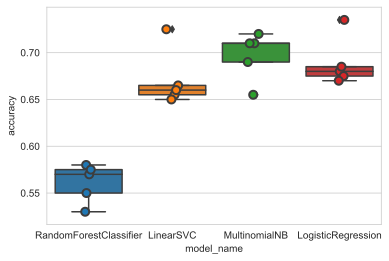

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [36]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                0.67
LogisticRegression       0.69
MultinomialNB            0.70
RandomForestClassifier   0.56
Name: accuracy, dtype: float64

#### Model Evaluation - LinearSVC

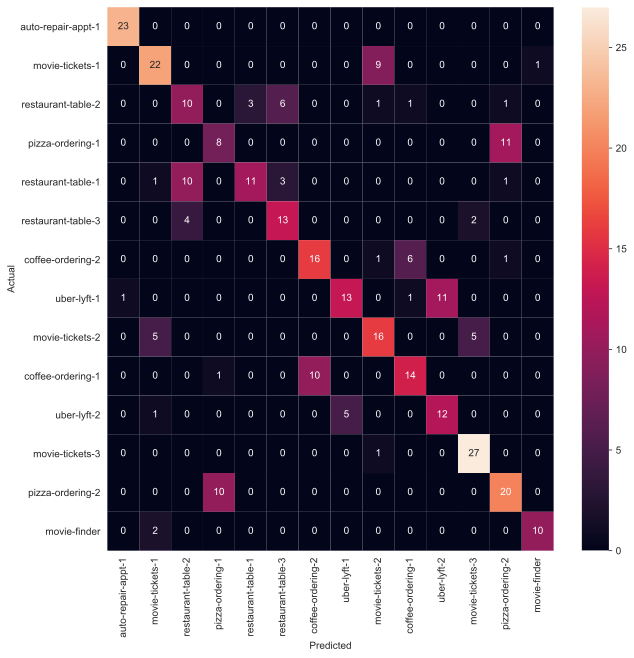

In [37]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, corpus_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Metrics For Each Class

In [38]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       0.96      1.00      0.98        23
   movie-tickets-1       0.71      0.69      0.70        32
restaurant-table-2       0.42      0.45      0.43        22
  pizza-ordering-1       0.42      0.42      0.42        19
restaurant-table-1       0.79      0.42      0.55        26
restaurant-table-3       0.59      0.68      0.63        19
 coffee-ordering-2       0.62      0.67      0.64        24
       uber-lyft-1       0.72      0.50      0.59        26
   movie-tickets-2       0.57      0.62      0.59        26
 coffee-ordering-1       0.64      0.56      0.60        25
       uber-lyft-2       0.52      0.67      0.59        18
   movie-tickets-3       0.79      0.96      0.87        28
  pizza-ordering-2       0.59      0.67      0.62        30
      movie-finder       0.91      0.83      0.87        12

          accuracy                           0.65       330
         macro avg       0.66      0.65      0.65       33

#### Bag of Words Feature Extraction

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 2, 1, ..., 0, 0, 0],
       [0, 4, 4, ..., 0, 0, 0],
       ...,
       [0, 4, 3, ..., 1, 0, 0],
       [0, 1, 3, ..., 0, 1, 1],
       [0, 6, 5, ..., 0, 0, 0]], dtype=int64)

In [40]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,ok,yes,okay,want,pm,order,thank,time,one,tickets,great,please,...,majestic,majectic,limburg,lindburg,wrigley,tutto,italiano,tami,lynn,associated,tlbrownmyemailnet,bradenton,uner,raymond,met
0,0,1,1,9,0,0,0,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,1,6,1,0,1,6,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,4,4,2,0,0,0,1,0,0,0,0,10,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,5,4,0,2,3,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,10,7,3,5,0,2,0,4,0,0,2,0,6,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,1,3,2,0,2,0,1,1,0,3,0,4,3,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,1,0,0,3,0,0,2,0,0,1,0,...,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0
997,0,4,3,8,3,0,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
998,0,1,3,0,2,0,1,0,0,1,2,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


#### Bag of Words Feature Benchmarking with Naive Bayes Classifier

In [41]:
features = cv.fit_transform(doc_lst).toarray()
labels = corpus_df.category
print (features.shape) 
print (labels.shape)

(1000, 5916)
(1000,)


In [27]:
#X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.25,random_state=123)

In [42]:
naive = MultinomialNB()
classifier = naive.fit(X_train, y_train)
predict = classifier.predict(X_test)

In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predict,y_test)
cm

array([[23,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0, 15,  0, 10,  9,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 15,  0,  0,  0,  0,  0,  1,  0,  0, 12,  0],
       [ 0,  0,  3,  0, 12,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  3,  9,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 20,  0,  0, 16,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  2,  0,  0,  0],
       [ 0, 16,  0,  0,  0,  0,  0,  1, 22,  0,  0,  4,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  4,  0,  0,  8,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 13,  0,  0, 16,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0, 24,  0,  1],
       [ 0,  0,  1,  4,  1,  0,  0,  0,  0,  0,  0,  0, 18,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10]],
      dtype=int64)

In [44]:
accuracy = cm.trace()/cm.sum()
print(accuracy)

0.6666666666666666


In [45]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict, target_names=corpus_df['Instruction_id'].unique()))

precision    recall  f1-score   support

auto-repair-appt-1       0.96      1.00      0.98        23
   movie-tickets-1       0.94      0.50      0.65        32
restaurant-table-2       0.44      0.68      0.54        22
  pizza-ordering-1       0.54      0.79      0.64        19
restaurant-table-1       0.75      0.46      0.57        26
restaurant-table-3       0.64      0.47      0.55        19
 coffee-ordering-2       0.56      0.83      0.67        24
       uber-lyft-1       0.86      0.46      0.60        26
   movie-tickets-2       0.50      0.85      0.63        26
 coffee-ordering-1       0.67      0.32      0.43        25
       uber-lyft-2       0.55      0.89      0.68        18
   movie-tickets-3       0.86      0.86      0.86        28
  pizza-ordering-2       0.75      0.60      0.67        30
      movie-finder       1.00      0.83      0.91        12

          accuracy                           0.67       330
         macro avg       0.71      0.68      0.67       33

In [42]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in doc_lst]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['trim', 'challenger', 'lauren', 'sxt', 'matt'],
 'pizza': ['hut', 'sausage', 'large', 'toppings', 'pan'],
 'terminator': ['abyss', 'judgment', 'sigourney', 'weaver', 'vi'],
 'star': ['wars', 'jedi', 'series', 'vi', 'rating'],
 'audi': ['appoint', 'powers', 'ken', 'jones', 'q'],
 'east': ['richardson', 'uncle', 'awang', 'crystal', 'papa'],
 'korean': ['countryside', 'bbgo', 'pinellas', 'lauderhill', 'pig'],
 'playing': ['theaters', 'flexible', 'shows', 'billings', 'rethink']}

#### Visualizing word embeddings

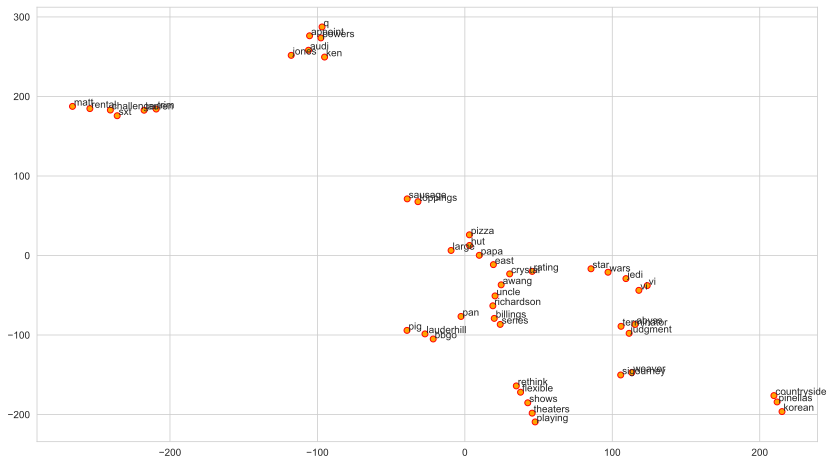

In [43]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our sample corpus

In [44]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in doc_lst]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [46]:
w2v_model.wv['sky']

array([ 0.13863125, -1.9728951 ,  0.13722275,  1.3456321 , -1.0225046 ,
        0.20253977, -0.19561672,  2.4790606 , -0.03430973, -0.5712002 ],
      dtype=float32)

#### Build framework for getting document level embeddings

In [48]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [49]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9
0,0.72,1.32,-0.76,-0.11,0.87,-1.93,0.79,-0.11,-2.17,-1.38
1,-0.06,1.76,-0.77,0.29,0.78,-1.65,0.67,-0.36,-2.90,-0.87
2,1.69,-0.08,-1.29,-0.16,-1.20,4.09,2.36,2.11,-1.32,-2.62
3,-0.28,0.27,0.16,-0.70,2.24,0.91,0.00,0.16,-1.47,-0.61
4,2.68,0.51,-1.66,-1.05,-0.07,1.46,-0.41,-1.46,-0.94,2.61
...,...,...,...,...,...,...,...,...,...,...
995,-0.21,-0.28,-2.31,-2.88,0.22,0.69,-1.93,-1.57,0.18,2.60
996,-0.76,-0.30,0.28,-0.41,2.93,1.16,-0.34,1.17,-1.52,-0.80
997,-0.49,1.11,-1.25,0.99,-0.33,0.62,-0.38,0.31,-2.13,0.20
998,0.62,-0.07,-0.97,-0.23,1.31,3.39,0.31,-1.24,-1.46,-1.40


#### GloVe Embeddings with spaCy

In [53]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [55]:
unique_words = list(set([word for sublist in [doc.split() for doc in doc_lst] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
crazy,-0.37,-0.10,-0.14,-0.12,-0.03,0.27,0.13,0.03,0.23,1.85,-0.30,0.02,-0.06,0.00,-0.11,...,0.29,0.27,-0.14,0.09,0.08,-0.17,-0.20,0.14,0.06,-0.01,0.31,-0.02,0.02,0.30,0.03
futuristic,0.70,-0.55,0.10,-0.43,0.09,0.08,0.07,0.06,-0.06,0.55,0.28,-0.15,-0.01,0.44,0.18,...,-0.30,0.02,-0.16,-0.51,-0.33,-0.53,0.03,0.49,0.28,-0.58,0.29,0.11,0.55,-0.04,0.50
sort,-0.07,0.02,-0.10,0.23,0.00,0.19,-0.08,-0.34,0.07,2.22,-0.14,-0.01,0.10,-0.17,-0.08,...,-0.16,-0.18,-0.27,-0.01,-0.32,-0.15,0.06,0.07,0.14,0.06,0.35,-0.05,-0.00,0.04,0.23
escape,0.53,-0.22,-0.05,0.00,0.03,-0.04,-0.08,0.23,0.07,2.35,-0.24,-0.28,-0.36,0.44,-0.25,...,-0.36,0.20,0.26,0.36,-0.15,0.06,0.28,-0.29,-0.09,0.11,0.13,-0.09,0.62,-0.19,-0.14
machiato,0.15,-0.46,-0.26,1.06,0.18,-0.32,-0.04,0.40,0.15,-1.04,0.04,-0.33,-0.67,-0.55,0.64,...,-0.66,-0.07,0.29,-1.43,0.43,0.66,-0.24,-0.38,-0.54,0.46,0.32,0.04,-0.65,0.38,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oldtown,0.78,-0.63,-0.17,0.51,0.37,0.27,-0.09,0.28,0.79,-1.19,-0.38,-0.83,-0.35,0.01,-0.44,...,0.28,0.30,-0.17,-0.25,0.48,0.79,-0.30,-0.03,-0.60,-0.07,0.54,0.30,0.66,-0.90,-0.27
pittsburgh,0.11,-0.12,-0.31,-0.35,0.61,-0.00,0.19,0.25,0.75,0.52,-1.08,-0.26,0.28,-0.04,-0.22,...,0.14,0.17,0.32,0.16,0.34,0.35,-0.26,-0.10,0.38,-0.02,-0.41,-0.01,-0.03,-0.40,0.41
kobe,-0.78,-0.45,0.92,-0.71,0.87,0.05,0.16,-0.23,0.33,-0.03,-0.88,0.05,-0.44,0.18,0.36,...,0.62,-0.13,0.54,-0.19,-0.19,1.29,0.48,-0.69,-0.19,0.89,-0.35,-0.39,-0.23,0.22,0.27
pastry,0.69,-0.10,0.33,-0.31,0.08,-0.24,0.12,0.36,0.15,0.89,-0.02,0.43,-0.22,0.12,0.18,...,0.12,0.44,-0.07,-0.35,-0.15,1.19,0.78,-0.04,-0.26,-0.60,0.05,0.80,-0.54,0.06,0.62


In [58]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in doc_lst]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [59]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['drama', 'moment', 'indianapolis', 'wars', 'reserve'],
 'pizza': ['pepperoni', 'pizzas', 'cheese', 'sausage', 'crust'],
 'terminator': ['terminal', 'airport', 'jfk', 'international', 'washington'],
 'star': ['wars', 'born', 'recommendations', 'recommended', 'cameron'],
 'audi': ['costs', 'austin', 'general', 'cinema', 'fee'],
 'east': ['broadway', 'tampa', 'broad', 'chicago', 'pies'],
 'korean': ['belt', 'anywhere', 'blvd', 'grill', 'bbq'],
 'playing': ['tickets', 'movie', 'showing', 'theater', 'pet']}

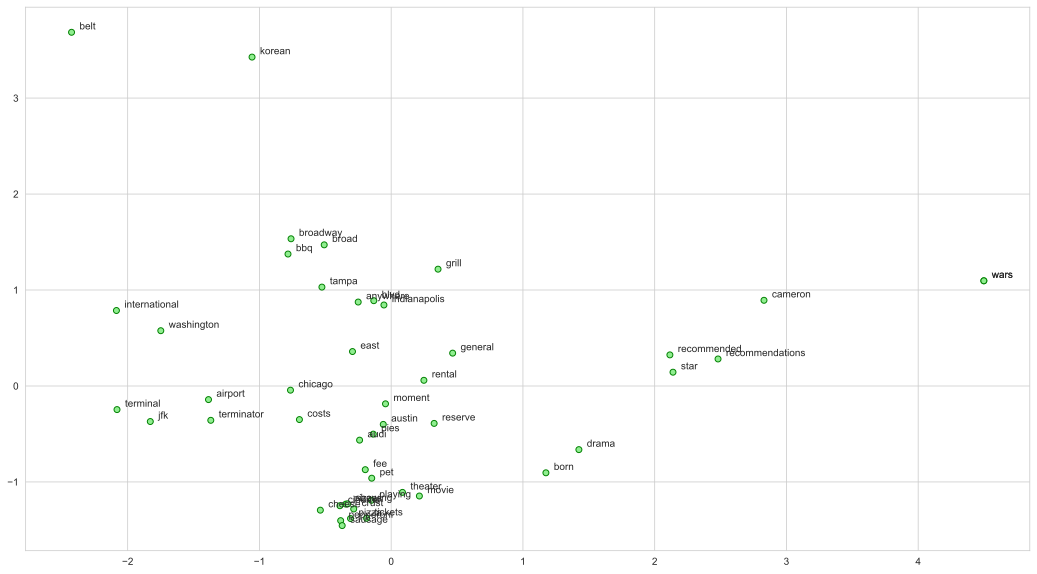

In [60]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [61]:
ft_model.wv['rental']

array([-0.159931  , -0.4715582 ,  0.20080853, -0.37942922,  0.32679608,
       -0.5193822 ,  0.03108732,  0.13750559, -0.19606566,  0.12210814,
       -0.16109028,  0.08520142, -0.4555036 , -0.04613556,  0.41115522,
        0.00039929, -0.33218724, -0.1443286 ,  0.38980013, -0.01459857,
        0.42017284, -0.12342175, -0.03493973, -0.18944828, -0.16120075,
        0.06246398, -0.20994098,  0.38306248, -0.12644786, -0.0828645 ,
       -0.11812786,  0.0071423 ,  0.28318402,  0.35417414,  0.07532656,
       -0.32349357, -0.21564   ,  0.49176434,  0.05538502,  0.15074153,
        0.13661136, -0.10369486,  0.30871505, -0.18018603, -0.02858236,
       -0.20835625, -0.12001361, -0.22068554,  0.41642517, -0.6025088 ,
        0.4114399 ,  0.4526229 ,  0.56534636,  0.26406825,  0.02590969,
       -0.00972404, -0.04670722,  0.11215308,  0.11989847, -0.19483012,
       -0.5224256 , -0.132594  ,  0.0243189 , -0.08337057,  0.1091096 ,
        0.3639107 , -0.3165195 ,  0.38650432,  0.28302038,  0.22

In [63]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.20476826
0.7579293


In [65]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies
